In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(modelr)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.1          ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.1          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────────────────────

In [2]:
zm_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"


#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
zm_input <- here(zm_working_dir,"00.data/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
zm_meta <- here(zm_working_dir,"00.data/Zm.leaf_annot.V5.meta.frozen.txt")
zm_gene <- here(zm_working_dir,"00.data/Zm.markers.leaf.txt")
zm_gene_DA <- here(zm_working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

zm_meta_data <- read.delim(zm_meta)
zm_gene_markers <- read.delim(zm_gene)
zm_gene_markers <- zm_gene_markers  %>%
    arrange(type)

zm_all_markers <- zm_gene_markers$geneID

zm_raw_cpm_counts_all_genes <- read_delim(zm_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

zm_merged_meta_cpm_information <- left_join(zm_meta_data, zm_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(final_annotation, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
zm_merged_meta_cpm_information_copied <- zm_merged_meta_cpm_information
zm_catch <- zm_merged_meta_cpm_information_copied  %>%
    group_by(final_annotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



zm_caught_values <- as_tibble(zm_catch)
zm_see <- ungroup(zm_merged_meta_cpm_information_copied)
zm_merged_meta_cpm_information_copied<- bind_cols(zm_merged_meta_cpm_information_copied,zm_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Zm")  %>% 
    group_by(final_annotation) %>%  
    mutate(log_cpm  = log(grouped_CPM))


#Apply quantile normalization
zm_merged_meta.quant_norm <- zm_merged_meta_cpm_information_copied  %>% 
        group_by(final_annotation)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(zm_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)


zm_merged_meta_cpm_information_copied <- bind_cols(zm_merged_meta_cpm_information_copied, zm.quantile_normalized)


Rows: 22253352 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'final_annotation'. You can override using the `.groups` argument.


In [3]:

sb_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/sorghum_bicolor"


sb_input <- here(sb_working_dir,"00.data/sb.gene_accessability.iter_1.scores.txt")
sb_meta <- here(sb_working_dir, "00.data/Sb.leaf_annot.V5.meta.frozen.txt")

sb_gene <- here(sb_working_dir,"00.data/Sb.orthos_from.zm.markers.de_novo.all.leaf.visualize.txt")
sb_gene_DA <- here(sb_working_dir,"00.data/Sbicolorv5.1.gene.bed")
#prefix <- "TEST_SORGHUM_TEST"

sb_meta_data <- read.delim(sb_meta)
sb_gene_markers <- read.delim(sb_gene)
sb_gene_markers <- sb_gene_markers  %>%
    arrange(type)



all_markers <- sb_gene_markers$geneID
sb_raw_cpm_counts_all_genes <- read_delim(sb_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)


sb_merged_meta_cpm_information <- left_join(sb_meta_data, sb_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(final_annotation, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
sb_merged_meta_cpm_information_copied <- sb_merged_meta_cpm_information
sb_catch <- sb_merged_meta_cpm_information_copied  %>%
    group_by(final_annotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()


sb_caught_values <- as_tibble(sb_catch)
sb_see <- ungroup(sb_merged_meta_cpm_information_copied)
sb_merged_meta_cpm_information_copied <- bind_cols(sb_merged_meta_cpm_information_copied,sb_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Sb")  %>% 
    group_by(final_annotation) %>%  
    mutate(log_cpm  = log(grouped_CPM))

#Apply quantile normalization
sb_merged_meta.quant_norm <- sb_merged_meta_cpm_information_copied  %>% 
        group_by(final_annotation)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

sb.quantile_normalized <- as_tibble(sb_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)

#Combine and re_name
sb_merged_meta_cpm_information_copied <- bind_cols(sb_merged_meta_cpm_information_copied, sb.quantile_normalized)



Rows: 35644015 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'final_annotation'. You can override using the `.groups` argument.


In [4]:
sb.cell_type_accessability <- sb_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, final_annotation, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)


zm.cell_type_accessability <- zm_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, final_annotation, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)
    

In [5]:
Sb.Zm.key_file <- read_delim("/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.orthos_from.Zm.key_file.txt", 
                             col_names = c("sb", "zm", "gene_name", "cell_type", "tis"))  %>% 
        distinct()

Rows: 260 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): sb, zm, gene_name, cell_type, tis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
head(zm.cell_type_accessability)

geneID,Zm.bundle_sheath,Zm.companion_cells,Zm.epidermis,Zm.mesophyll,Zm.mesophyll;developing,Zm.phloem_sieve_elements,Zm.procambial_meristem,Zm.protoderm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zm00001eb000010,10.3068512,10.89547,6.4905507,8.0307958,22.80993,6.386535,7.379652,6.571043
Zm00001eb000020,3.2547951,10.89547,5.8073348,2.7247343,10.13775,11.860708,0.000000,6.571043
Zm00001eb000050,0.3616439,0.00000,0.5124119,0.5736283,0.00000,1.824724,0.000000,0.000000
Zm00001eb000060,22.4219220,25.42277,27.6702424,19.0731400,26.61158,26.458502,16.604216,22.998650
Zm00001eb000070,10.1260293,13.61934,10.2482379,7.6005746,0.00000,8.211259,16.604216,16.174875
Zm00001eb000080,41.9506927,65.37283,45.0922470,43.7391557,26.61158,48.811375,35.053346,39.426257


In [7]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "fama_v4v5count_1", 
                      "dct2", "shr2h", "shr2", "gl1", "ZmAAP6_4", "bhlh43","ocl1",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "ZmSMXL5")

good_gene_markers <- Sb.Zm.key_file  %>% 
    filter(gene_name %in% good_marker_list)  %>% 
    select(-cell_type, -tis)



In [8]:
final_combined_dataset <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    left_join(., sb.cell_type_accessability, by = c("sb" = "geneID"))  %>% 
    rowwise()  %>% 
    mutate(unique_count = n())

generate_corr_matrix <- final_combined_dataset  %>% 
    select(-sb, -zm, -gene_name, -unique_count)

cell_type_corr_matrix <- cor(generate_corr_matrix)

In [10]:
sum(is.na(generate_corr_matrix))

[1] 0

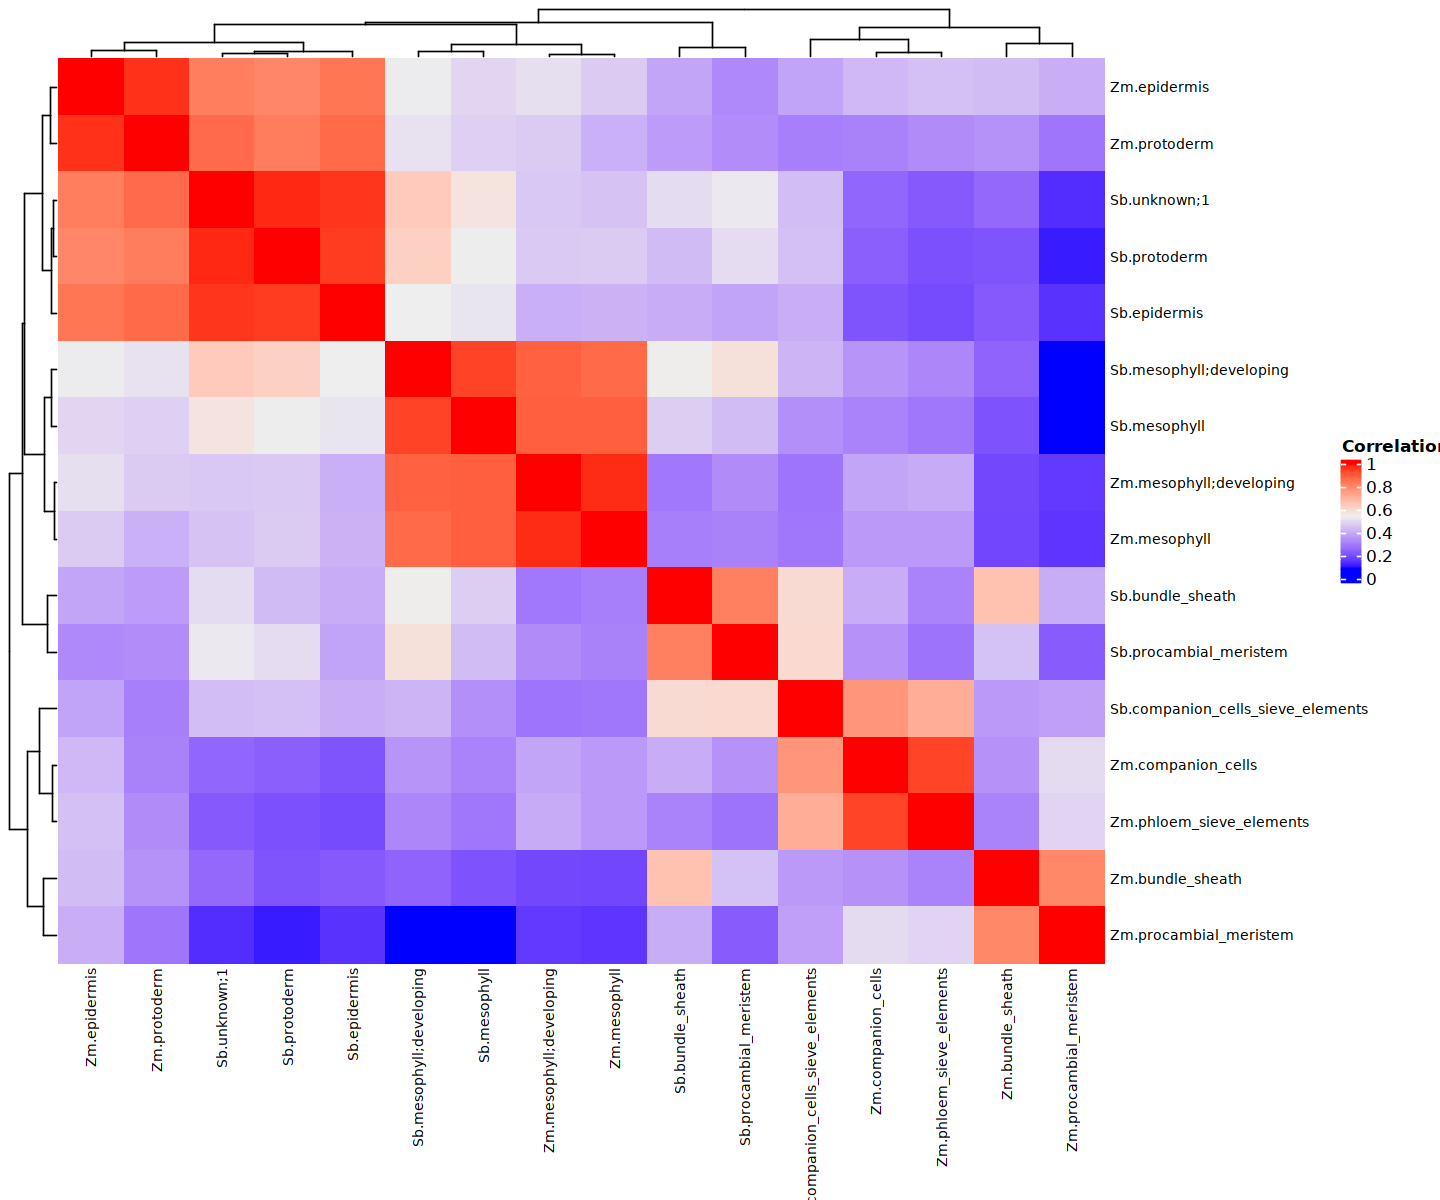

In [237]:
library(ComplexHeatmap)

options(repr.plot.width=12, repr.plot.height=10)
zm_vs_sb_all_vs_all_markers <- Heatmap(cell_type_corr_matrix,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

zm_vs_sb_all_vs_all_markers

In [210]:
zm.cell_types <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    select(-sb, -zm, -gene_name)
sb.cell_types <- left_join(good_gene_markers, sb.cell_type_accessability, by = c("sb" = "geneID"))  %>% 
    select(-sb, -zm, -gene_name)



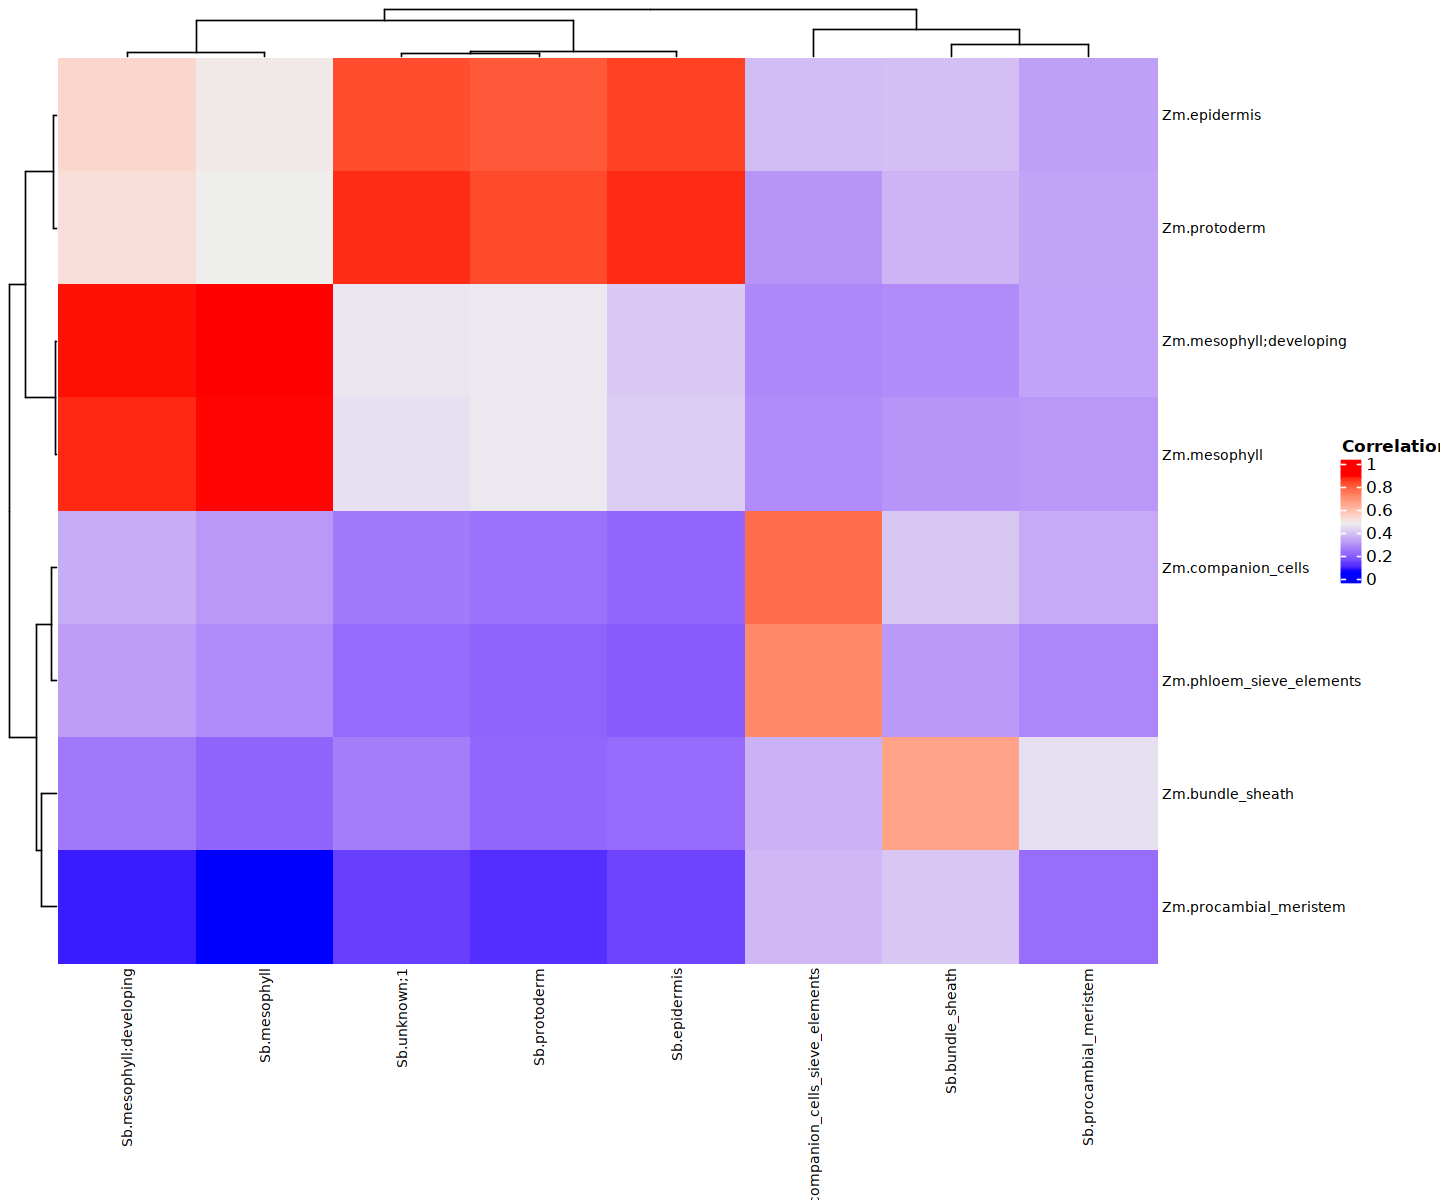

In [211]:



options(repr.plot.width=12, repr.plot.height=10)
sep_corr_matrix <- cor(zm.cell_types, sb.cell_types)
zm_vs_sb_markers <- Heatmap(sep_corr_matrix,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_sb_markers




In [246]:
sb.cell_types.dropped

Sb.bundle_sheath,Sb.companion_cells_sieve_elements,Sb.epidermis,Sb.mesophyll,Sb.mesophyll;developing,Sb.procambial_meristem,Sb.protoderm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55.629547,4.176101,2.0886908,5.0760422,1.959444,8.469023,2.283186
5.960309,5.568134,1.8798217,3.1506469,2.694236,1.058628,1.522124
3.689715,5.568134,0.8354763,0.7001437,1.469583,6.351767,2.092921
55.629547,4.176101,2.0886908,5.0760422,1.959444,8.469023,2.283186
5.960309,5.568134,1.8798217,3.1506469,2.694236,1.058628,1.522124
3.689715,5.568134,0.8354763,0.7001437,1.469583,6.351767,2.092921
55.629547,4.176101,2.0886908,5.0760422,1.959444,8.469023,2.283186
5.960309,5.568134,1.8798217,3.1506469,2.694236,1.058628,1.522124
3.689715,5.568134,0.8354763,0.7001437,1.469583,6.351767,2.092921


In [247]:
sep_corr_matrix

,Sb.bundle_sheath,Sb.companion_cells_sieve_elements,Sb.epidermis,Sb.mesophyll,Sb.mesophyll;developing,Sb.procambial_meristem,Sb.protoderm
Zm.bundle_sheath,0.6589787,0.3590066,0.2210632,0.20625109,0.24563202,0.4483094,0.2112210
Zm.companion_cells,0.4016011,0.7714422,0.2115967,0.31035729,0.34887824,0.3450613,0.2337591
Zm.epidermis,0.3861209,0.3803161,0.8466016,0.48933294,0.53540632,0.3250171,0.8082980
Zm.mesophyll,0.3022056,0.2838273,0.4140528,0.89338845,0.87287551,0.3101272,0.4679420
Zm.mesophyll;developing,0.2866435,0.2785050,0.4065252,0.89485557,0.88967625,0.3311062,0.4663564
Zm.phloem_sieve_elements,0.3123755,0.7138153,0.1922769,0.28407106,0.32000401,0.2766010,0.2030297
Zm.procambial_meristem,0.4001157,0.3732422,0.1450777,0.06037963,0.08380595,0.2256963,0.1092981
Zm.protoderm,0.3653019,0.3030682,0.8718614,0.47857855,0.51597078,0.3337697,0.8318763


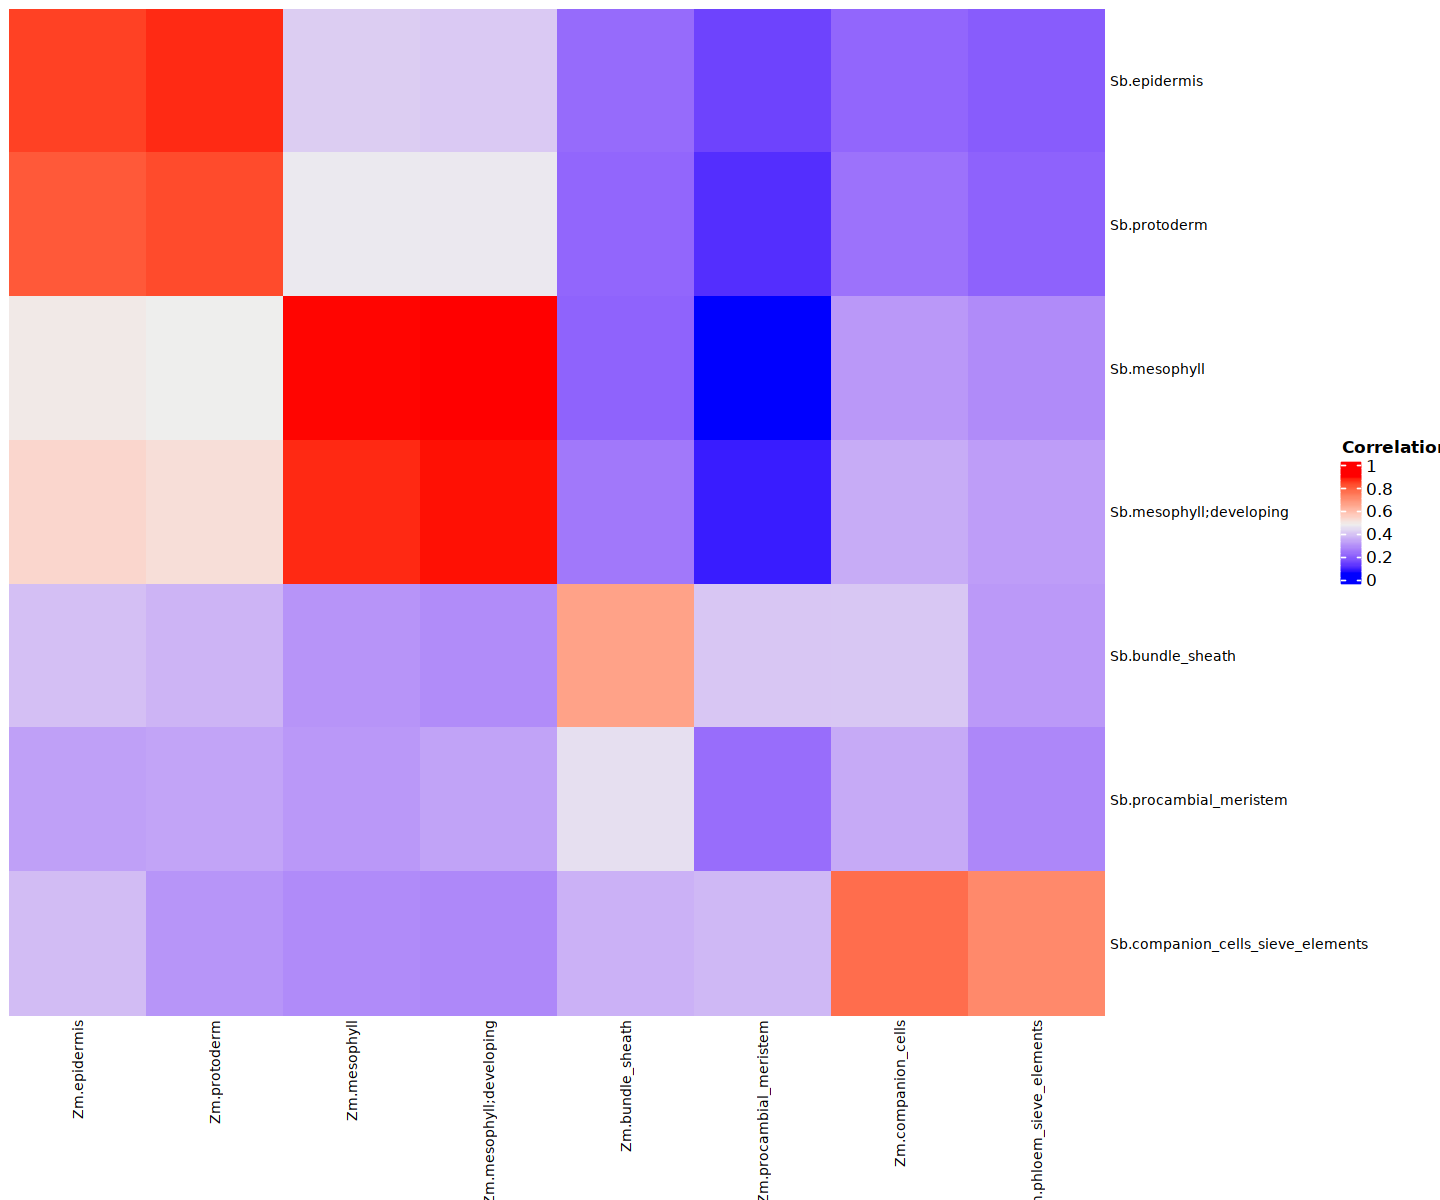

In [252]:
## Generating Orderer on Marker Genes 
sb_order <- c('Sb.epidermis',
    'Sb.protoderm',
    'Sb.mesophyll',
    'Sb.mesophyll;developing',
    'Sb.bundle_sheath',
    'Sb.procambial_meristem',
    'Sb.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)

zm.cell_types.dropped <- zm.cell_types
sb.cell_types.dropped <- sb.cell_types  %>% 
    select(-"Sb.unknown;1")

options(repr.plot.width=12, repr.plot.height=10)
marker_corr_matrix <- cor((sb.cell_types.dropped), (zm.cell_types.dropped))


Heatmap(marker_corr_matrix,
        row_order = sb_order,
        column_order = zm_order,
        column_names_gp = grid::gpar(fontsize = 8),
        row_names_gp = grid::gpar(fontsize = 8),
        heatmap_legend_param = list(
            title = "Correlation",
            legend_width = unit(6, "cm")))
#zm_vs_sb_markers_ordered

In [212]:
## Working now on Single Copy Ortholouges

zm_base <- "Zm"
sb_base <- "Sobic"

Sb_vs_Zm_orthos <- read_delim("/scratch/jpm73279/13.ACR_CNS_analysis/01.analysis/run_orthofinder/2022-06-21_plant_genomes_grass_lineages/OrthoFinder/Results_Jun22/Orthologues/Orthologues_Sbicolor.prot/Sbicolor.prot__v__Zm-B73.prot.tsv") 

#Gross output here that needs to be fixed from orthofinder.
colnames(Sb_vs_Zm_orthos) <- sub("-", "_", colnames(Sb_vs_Zm_orthos), fixed = TRUE)

Rows: 20081 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Orthogroup, Sbicolor.prot, Zm-B73.prot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [213]:
Sb_vs_Zm_orthos.fixed <- Sb_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(Sb_count = str_count(Sbicolor.prot, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(Sb_count == 0 & Zm_count == 0) %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    mutate(sb_gene = str_replace(Sbicolor.prot, "\\.[^\\.]*$", ""))
    


In [214]:
sb.zm.single_copy <- Sb_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, zm_gene, sb_gene)

In [215]:
sb.cell_types.all_orthos <- left_join(sb.zm.single_copy, sb.cell_type_accessability, by = c("sb_gene" = "geneID")) %>% 
    drop_na()


zm.cell_types.all_orthos <- left_join(sb.zm.single_copy, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(sb_gene %in% sb.cell_types.all_orthos$sb_gene)


In [216]:
sb.cell_types.all_orthos.final <- sb.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.all_orthos.final <- zm.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

In [217]:
dim(zm.cell_types.all_orthos.final)
dim(sb.cell_types.all_orthos.final)

[1] 9349    8

[1] 9349    8

In [218]:
head(sb.cell_types.all_orthos.final)

Sb.bundle_sheath,Sb.companion_cells_sieve_elements,Sb.epidermis,Sb.mesophyll,Sb.mesophyll;developing,Sb.procambial_meristem,Sb.protoderm,Sb.unknown;1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12.772090,9.744235,1.984256,18.2037375,55.109374,65.105614,39.004436,7.667854
17.880926,3.480084,14.725270,7.4390273,5.143542,20.643243,25.019918,33.307239
11.211057,14.616352,14.620836,5.6011500,14.940764,14.291476,37.862842,23.722422
1.135297,1.392034,7.258201,0.5251078,1.959444,4.234511,1.997788,2.396204
51.939832,36.888889,137.331422,140.2913036,103.115762,10.056965,25.876113,126.519583
2.554418,2.784067,9.399109,7.7890992,10.287083,3.175884,43.380543,45.048639


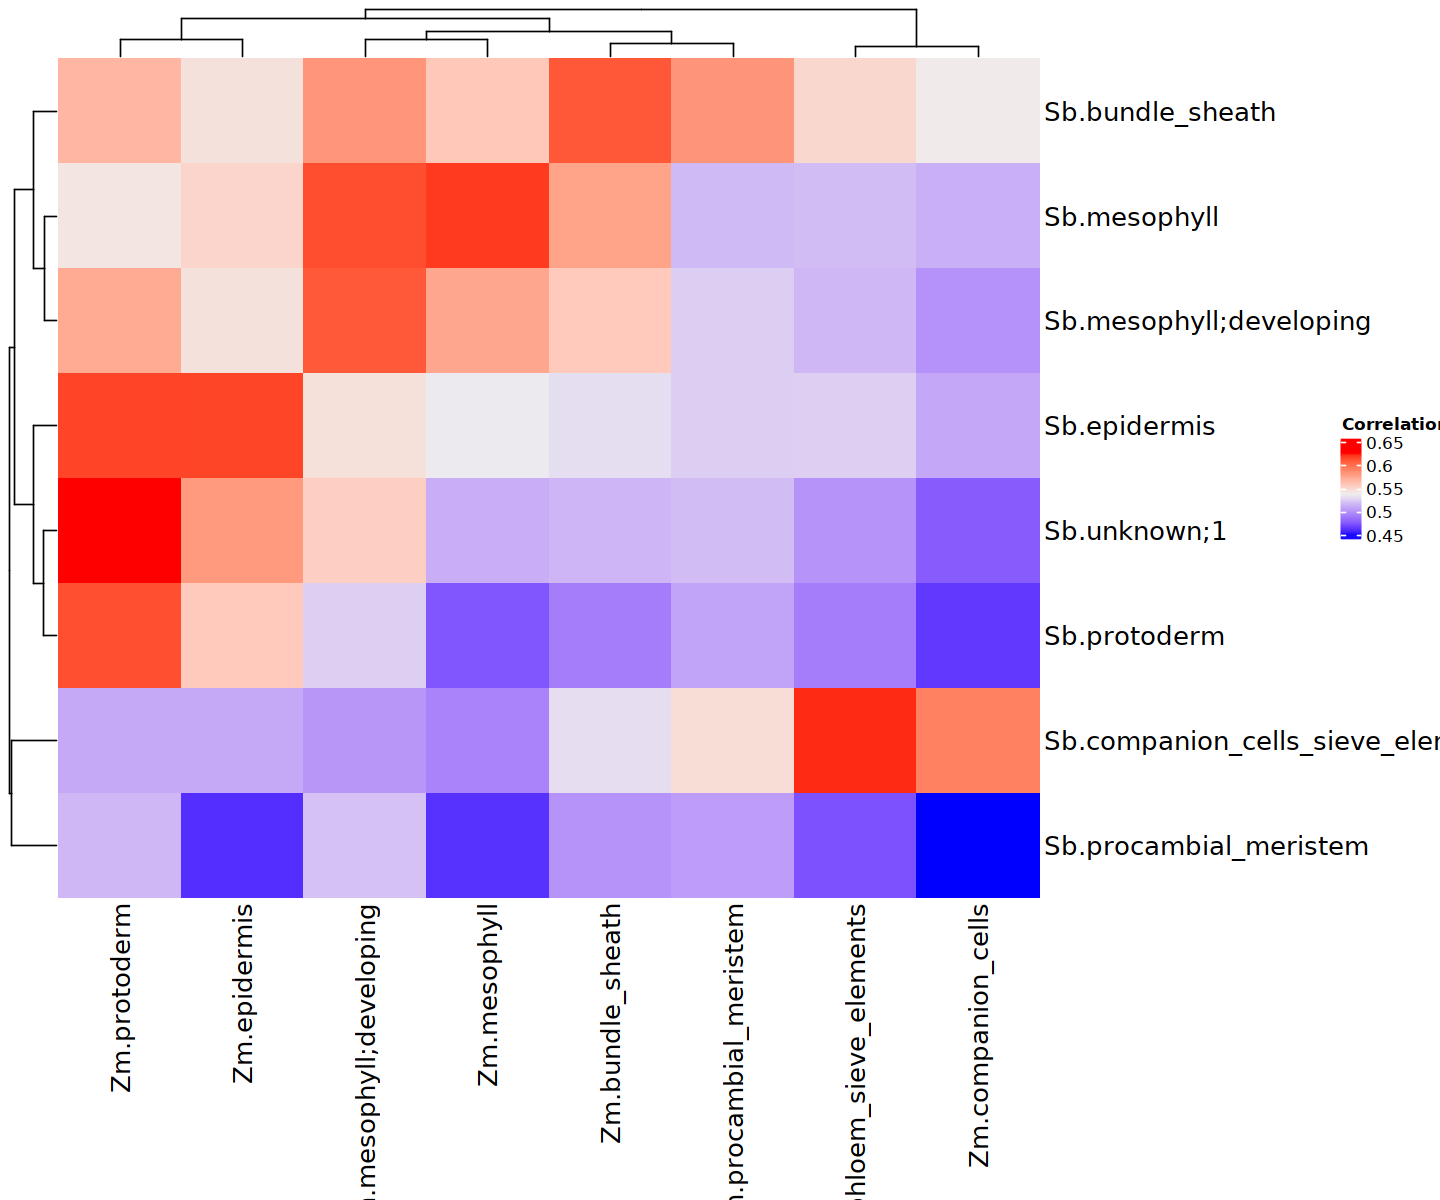

In [219]:
options(repr.plot.width=12, repr.plot.height=10)
all_orthos_corr <- cor((sb.cell_types.all_orthos.final), (zm.cell_types.all_orthos.final))
Heatmap(all_orthos_corr,
                                      column_names_gp = grid::gpar(fontsize = 15),
                                      row_names_gp = grid::gpar(fontsize = 15),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

# Selecting the 1000-2000 most variable single copy orthos

In [220]:
combined_sb_zm <- full_join(sb.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_sb_zm.subset <- combined_sb_zm  %>% 
    #dplyr::select(-zm_gene, -sb_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, sb_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)

Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


In [221]:
combined_sb_zm.subset.mean.var <- combined_sb_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_sb_zm.subset.mean.var)

combined_sb_zm.subset.mean.var.final <- combined_sb_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(2000)

Selecting by resid


In [222]:
combined_sb_zm.subset.mean.var.final.split <- combined_sb_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "sb_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, sb_gene)

In [223]:
sb.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split, sb.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

Joining, by = c("Orthogroup", "zm_gene", "sb_gene")
Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


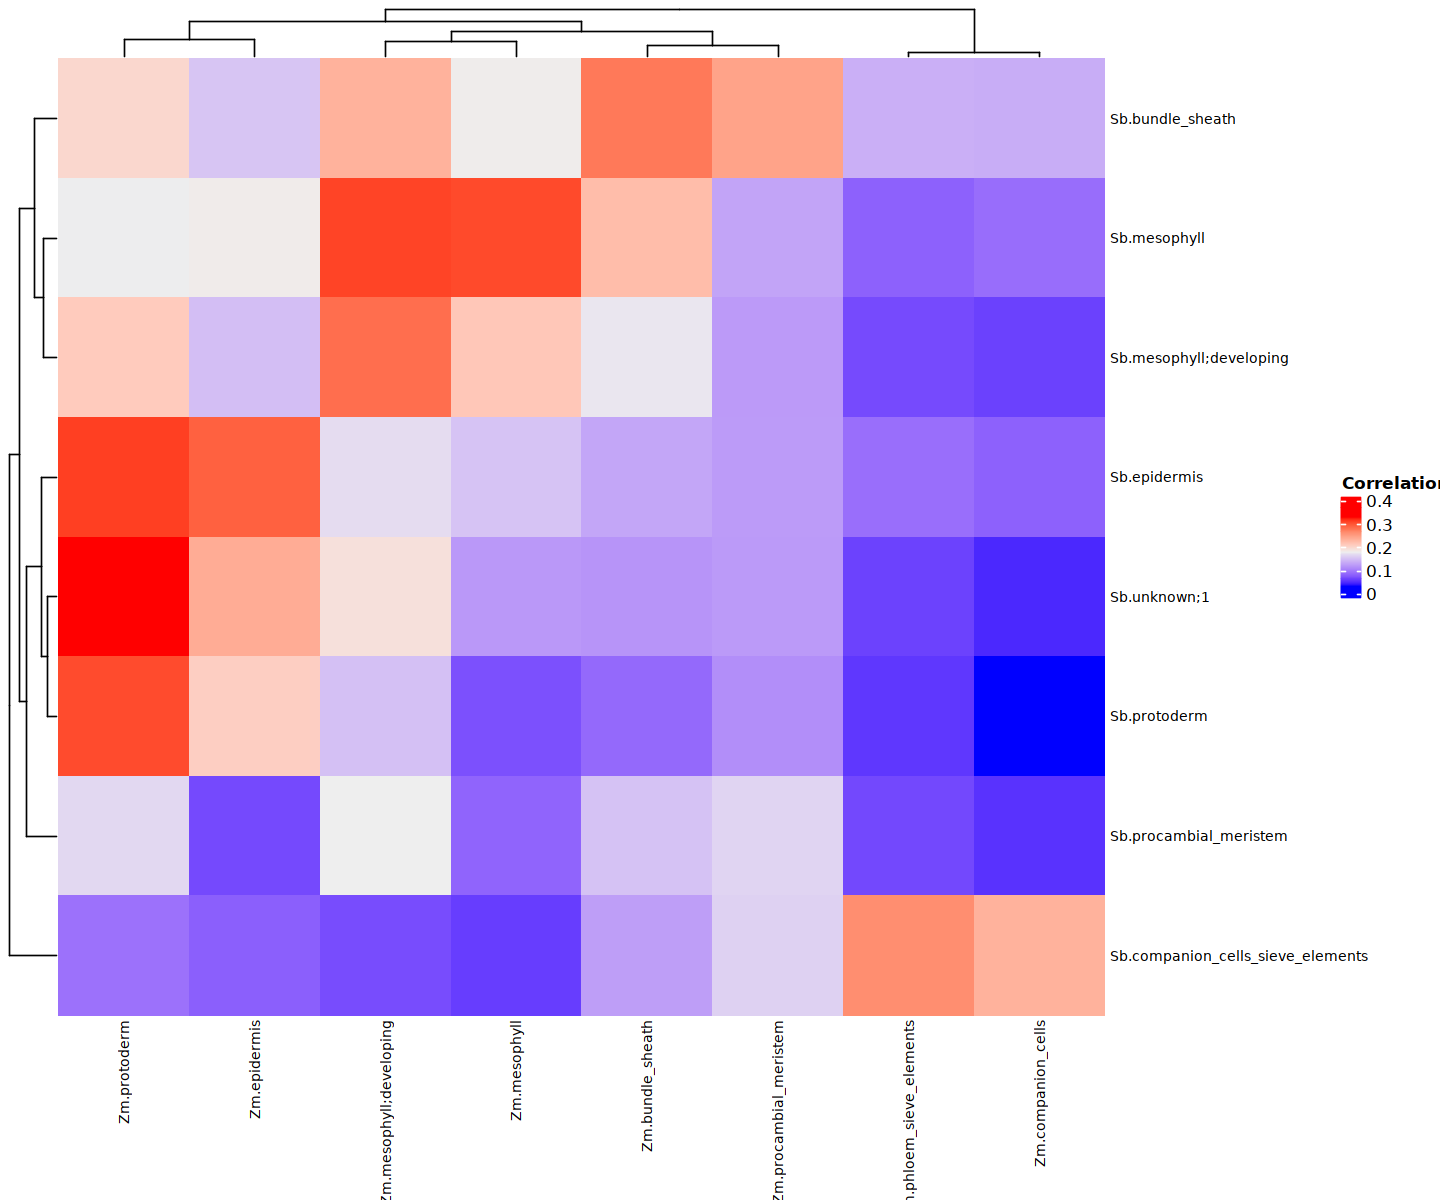

In [224]:
options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

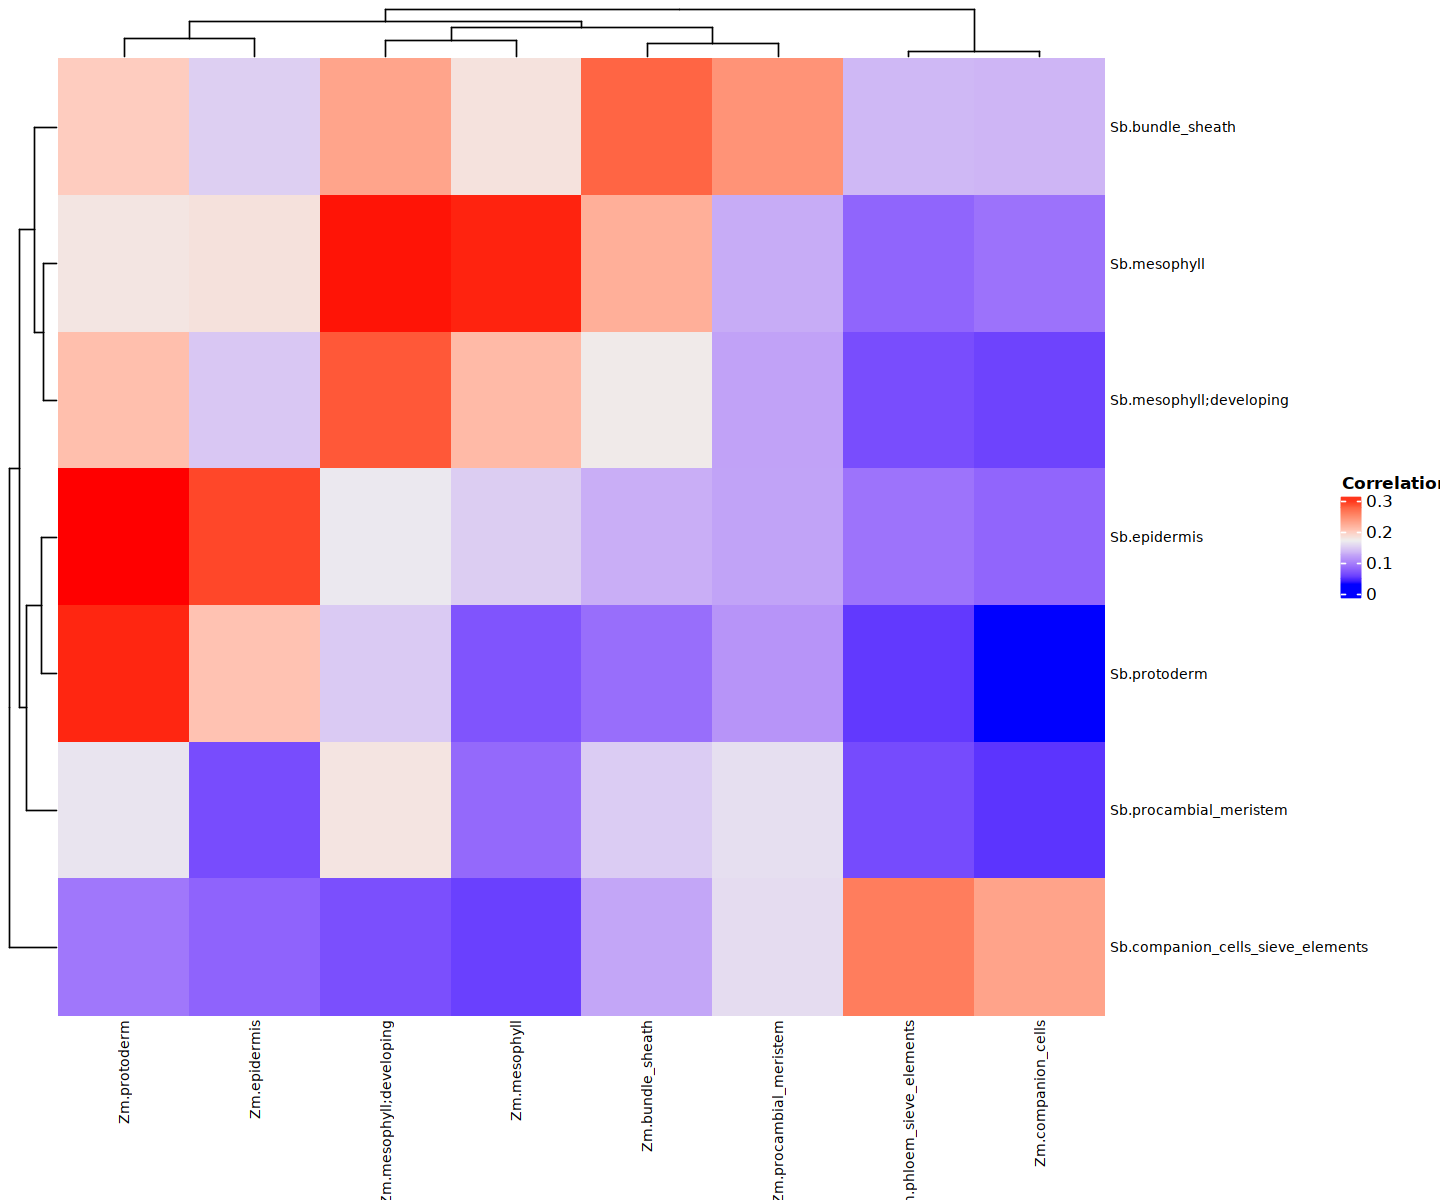

In [249]:
sb.cell_types.var_orthos.final.sub_select <- sb.cell_types.var_orthos.final  %>% 
    select(-"Sb.unknown;1")

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final

options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
zm_vs_sb_2000_orthos <-  Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_sb_2000_orthos


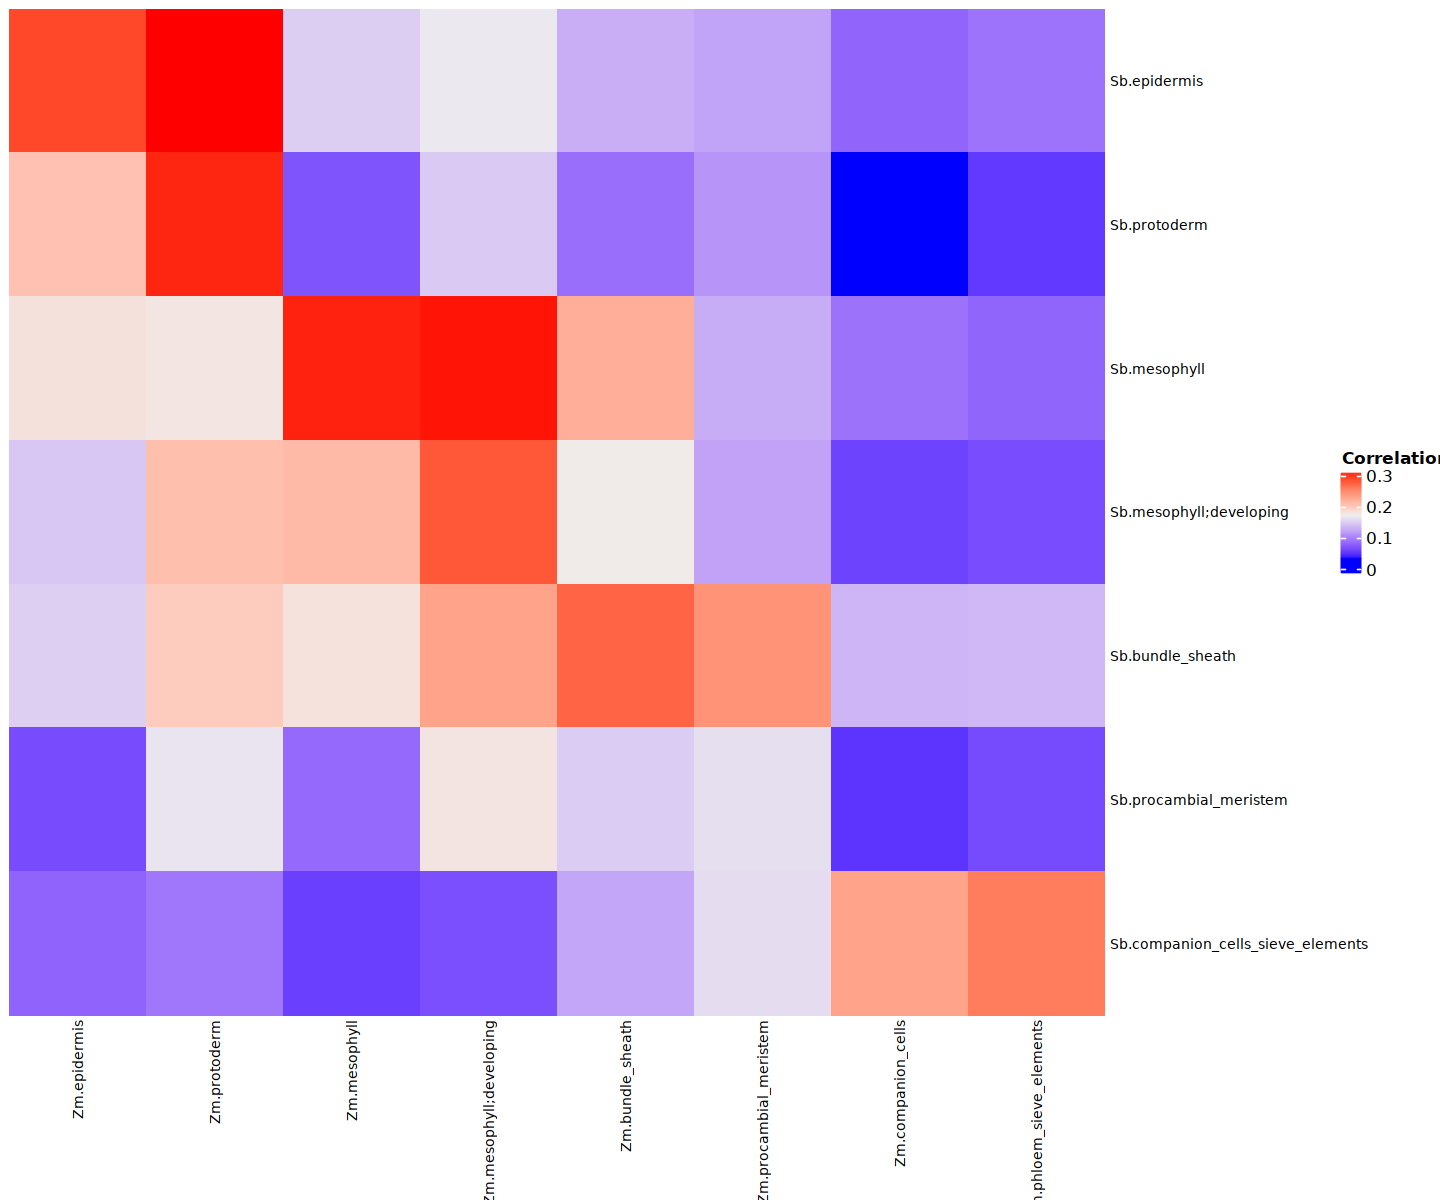

In [250]:
sb.cell_types.var_orthos.final.sub_select <- sb.cell_types.var_orthos.final  %>% 
    select(-"Sb.unknown;1")

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final


sb_order <- c('Sb.epidermis',
    'Sb.protoderm',
    'Sb.mesophyll',
    'Sb.mesophyll;developing',
    'Sb.bundle_sheath',
    'Sb.procambial_meristem',
    'Sb.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
zm_vs_sb_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = sb_order,
        column_order = zm_order,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_sb_2000_orthos_ordered

In [227]:
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (sb.cell_types.var_orthos.final.sub_select))
sb_vs_sb_2000_orthos<-  Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

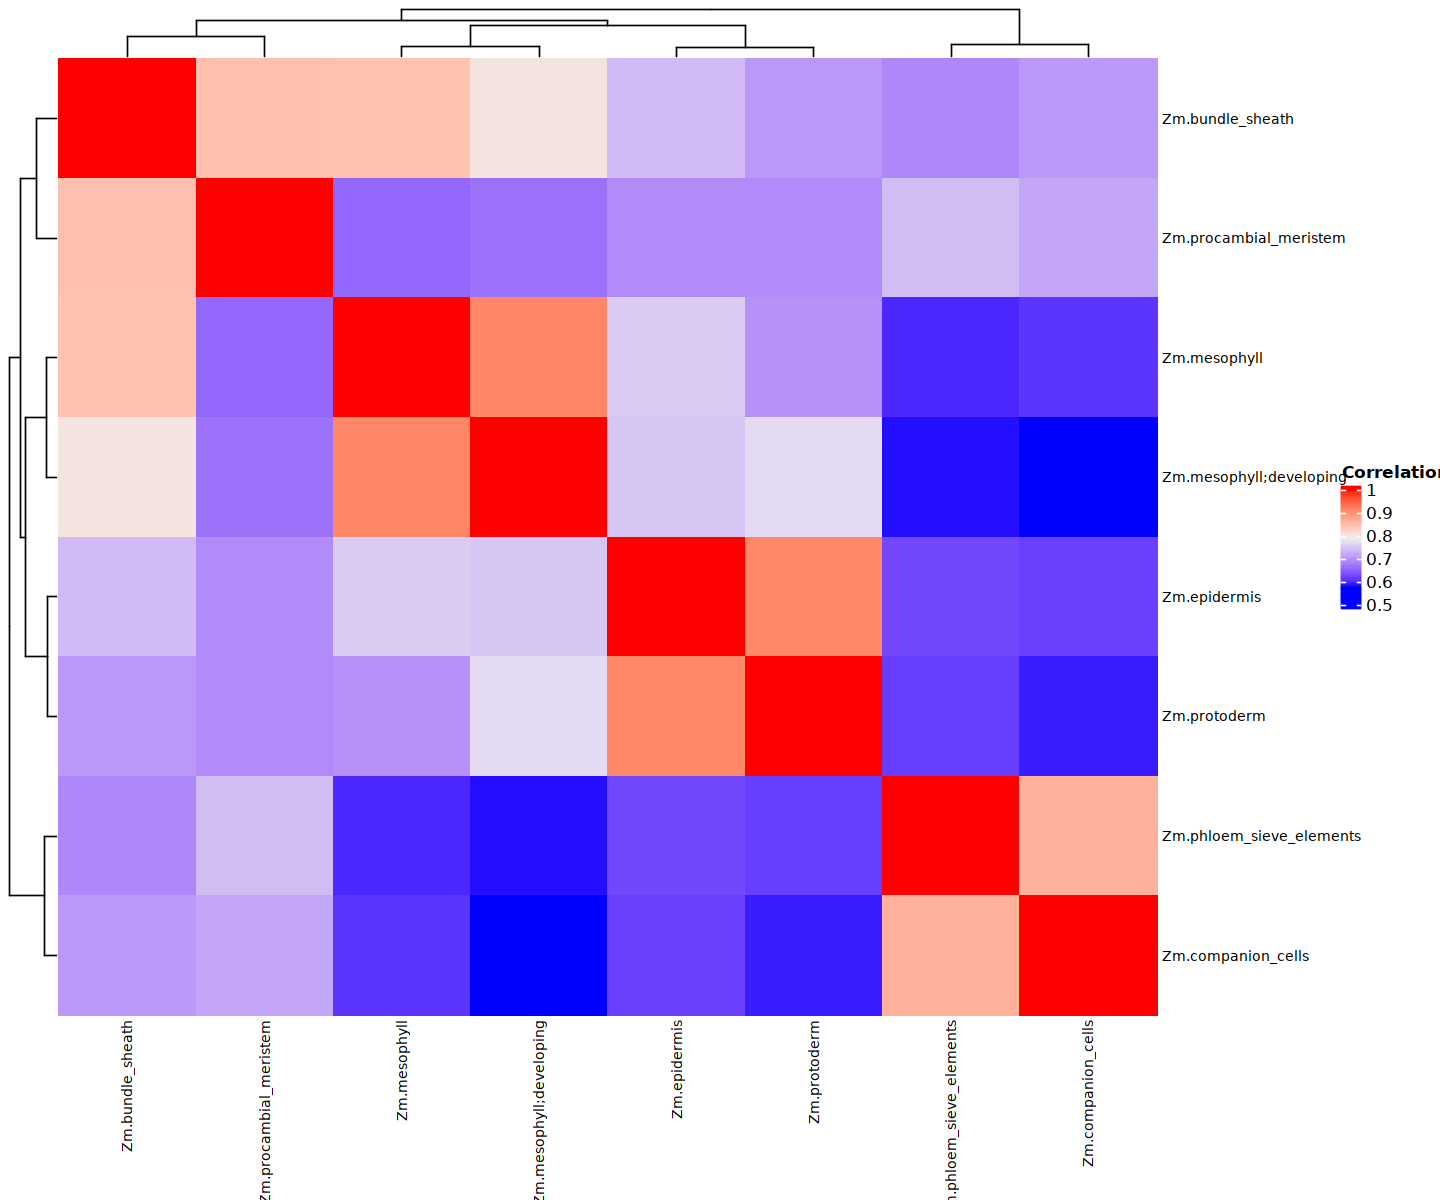

In [228]:
var.orthos.final <- cor((zm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm_vs_zm_2000_orthos <- Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_zm_2000_orthos 


Joining, by = c("Orthogroup", "zm_gene", "sb_gene")
Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


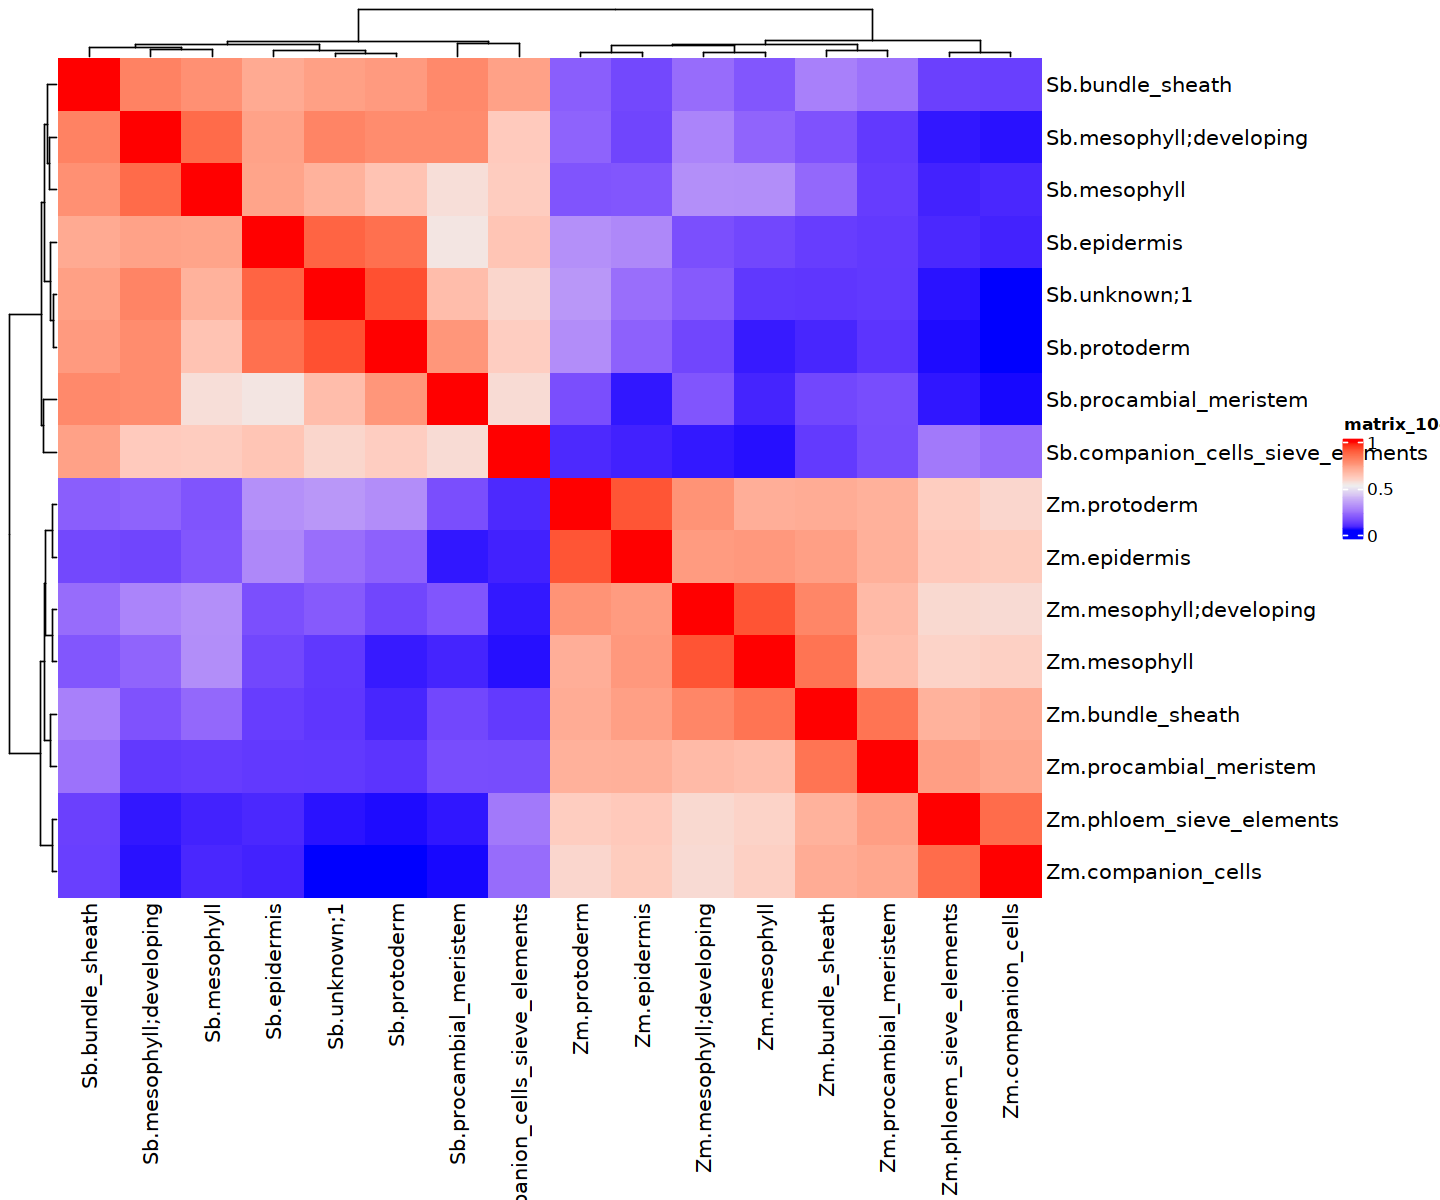

In [229]:
## Note that useful - Skipping this 
combined_sb_zm.subset.mean.var.final.split <- combined_sb_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "sb_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, sb_gene)

sb.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split, sb.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

all_vs_all <- bind_cols(zm.cell_types.var_orthos.final, sb.cell_types.var_orthos.final)

cell_type_corr_matrix <- cor(all_vs_all)


options(repr.plot.width=12, repr.plot.height=10)
Heatmap(cell_type_corr_matrix)

In [238]:
## Saving all heatmaps 

pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_sb_marker_corr_all_vs_all.pdf", width = 8, heigh = 5)
zm_vs_sb_all_vs_all_markers
dev.off()


pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_sb_marker_corr.pdf", width = 8, heigh = 5)
zm_vs_sb_markers
dev.off()


pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_sb_2000_var_orthos_ct_correlation.pdf", width = 8, heigh = 5)
zm_vs_sb_2000_orthos_ordered
dev.off()


pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Sb_vs_sb_2000_var_orthos.ct_correlation.pdf", width = 8, heigh = 5)
sb_vs_sb_2000_orthos
dev.off()


pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_zm_2000_var_orthos.ct_correlation.pdf", width = 8, heigh = 5)
zm_vs_zm_2000_orthos
dev.off()



png 
  2

png 
  2

png 
  2

png 
  2

png 
  2